## 1. Tracking a changing climate
<p>The climate is changing around the world. The impacts of climate change are felt in many different areas, but they are particularly noticeable in their effects on birds. Many bird species are moving north, if they can,  to stay in climatic conditions that are suitable for them.</p>
<p>Our analysis will use data from the <a href="https://www.metoffice.gov.uk/climate/uk/data/ukcp09">UK Met Office</a> together with records from the <a href="https://www.gbif.org/">Global Biodiversity Information Facility</a> to build our very own species distribution model using machine learning. This model will be able to predict where our bird species of interest is likely to occur in the future - information that is invaluable to conservation organization working on the ground to preserve these species and save them from extinction.</p>

<p>We will start by importing the climate data from a local <code>rds</code> file.</p>

In [1]:
# Importing tidyverse, raster, and sf packages
library(tidyverse)
library(sf)
library(raster)

# Importing the climate data from an rds file
climate  <- read_rds('datasets/climate_raster.rds')

# Have a look at the variables in the climate data
colnames(climate)

# Converting the dataframe to SpatialPixelDataFrame for plotting
climate_df <- mutate(
  .data = climate, 
  rasters = map(
    .x = rasters, 
    ~ as_tibble(as(.x, "SpatialPixelsDataFrame")))) %>%
  unnest(cols = c(rasters))

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Linking to GEOS 3.5.1, GDAL 2.2.2, PROJ 4.9.2
Loading required package: sp

Attaching package: 'raster'

The following object is masked from 'package:dplyr':

    select

The following object is masked from 'package:tidyr':

    extract



[1] "decade"  "rasters"

## 2. Mapping a changing climate
<p>We have loaded the pre-processed climate data and converted it to a <code>SpatialPixelDataFrame</code>. This data frame now contains all the information we need:</p>
<ul>
<li>the <code>decade</code> of observation,</li>
<li>spatial coordinates (<code>x</code>, <code>y</code>)</li>
<li>six selected climatic variables (<code>minimum.temperature</code>, <code>maximum.temperature</code>, <code>rainfall</code>, <code>wind.speed</code>, <code>snow.lying</code>, <code>air.frost</code>)</li>
</ul>
<p>The first step in any analysis is visualizing the data. Visualizing the data makes sure the data import worked, and it helps us develop intuition about the patterns in our dataset. Here we are dealing with spatial datas. We will start with two maps: one map of the climatic conditions in 1970, and one map of the climatic conditions in 2010. Our climate data has several variables, so let us pick <code>minimum.temperature</code> for now.</p>

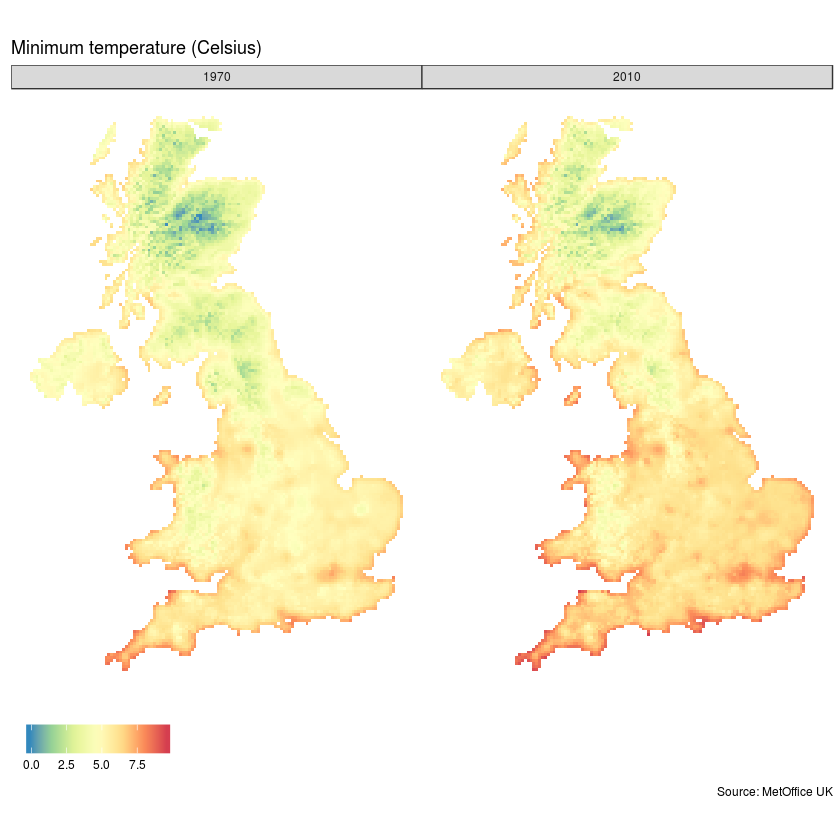

In [2]:
library(ggthemes)

# Creating the plot
ggp_temperature <- climate_df %>%
  filter(decade == 1970 | decade == 2010)%>%
  ggplot(aes(x = x, y = y)) + geom_tile(aes(fill = minimum.temperature)) +
  theme_map()+
  coord_equal()+
  facet_grid(~ decade) + scale_fill_distiller(palette = "Spectral") + 
  theme(legend.title = element_blank(), legend.position = "bottom") +
  labs(title = "Minimum temperature (Celsius)", caption = 'Source: MetOffice UK')

ggp_temperature

## 3. Fieldwork in the digital age – download the data
<p>Now we need to obtain species occurrence records. This used to be the main challenge in biogeography. Natural historians, such as Charles Darwin and Alexander von Humboldt, traveled around the globe for years on rustic sail ships collecting animal and plant specimens to understand the natural world.

In [3]:
library(rgbif)
source("datasets/occ_search.R")

# Calling the API to get the occurrence records of Scottish crossbill
gbif_response <- occ_search(
  scientificName = "Loxia scotica", country = "GB",
  hasCoordinate = TRUE, hasGeospatialIssue = FALSE, limit = 2000)

# Inspecting the class and names of gbif_response
class(gbif_response)
names(gbif_response)

head(data,n = 6)

[1] "gbif"

[1] "meta"      "hierarchy" "data"      "media"     "facets"

                                                                     
1 function (..., list = character(), package = NULL, lib.loc = NULL, 
2     verbose = getOption("verbose"), envir = .GlobalEnv)            
3 {                                                                  
4     fileExt <- function(x) {                                       
5         db <- grepl("\\\\.[^.]+\\\\.(gz|bz2|xz)$", x)              
6         ans <- sub(".*\\\\.", "", x)                               

## 4. Sorting out the bad eggs – data cleaning
<p>In particular, data collected at this large scale can have issues. Luckily, GBIF provides some useful metadata on each record.</p>
<p>Here are some criteria we can use: </p>
<ol>
<li>"issues" - We will only use records where no doubts about the observation were listed.</li>
<li>"license" - We will only use records under a creative commons license.</li>
<li>"date" - We will only use records between 1965 and 2015 because that matches our climate dataset.</li>
</ol>

In [4]:
library(lubridate)

birds_dated <- mutate(
  .data = gbif_response$data,
# Creating a new column which specifies the decade of observation
  decade = ymd_hms(eventDate) %>% round_date("10y") %>% year())

birds_cleaned <- birds_dated %>%
  filter(
    issues == "" &
    str_detect(license, "http://creativecommons.org/") &
    decade >= 1970, decade <= 2010
  ) %>%
  transmute(decade = decade, x = decimalLongitude, y = decimalLatitude) %>%
  arrange(decade)


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



## 5. Nesting the data
<p>We have cleaned the data, but there is a problem. We want to know the climatic conditions at the location of the bird observation <strong>at the time</strong> of the observation. This is tricky because we have climate data from multiple decades. How do we match each bird observation to the correct climate raster cell?</p>
<p>We can <code>nest()</code> data in a list column. The result is a data frame where the grouping columns do not change, and a list column of aggregated data from each group is added. List columns can hold many different kinds of variables such as vectors, data frames, and even objects. For example, the climate data that we imported earlier was already nested by decade and had a list column (<code>rasters</code>) that contained a <code>rasterStack</code> object for each decade.</p>

In [5]:
# "Nesting" the bird data
birds_nested <- birds_cleaned %>%
    group_by(decade) %>%
    nest(.key = "presences")


head(birds_nested)

# Calculating the total number of records per decade
birds_counted <- birds_nested %>%
  mutate(n = map_dbl(presences,nrow))

head(birds_counted)

Warning message:
"`.key` is deprecated"

decade,presences
1970,"-3.7742, -3.7996, -3.7424, -3.7742, -3.7536, 57.1484, 57.1748, 57.1368, 57.1484, 57.2490"
1980,"-3.805402, -3.604524, -4.323717, -3.712700, 57.164144, 57.327101, 56.670186, 57.163600"
1990,"-3.957270, -3.626685, -3.702624, -3.957270, -3.957270, -3.604524, -3.680281, -3.175040, -3.604524, 54.930540, 57.227079, 57.241025, 54.930540, 54.930540, 57.327101, 57.236949, 57.043710, 57.327101"


decade,presences,n
1970,"-3.7742, -3.7996, -3.7424, -3.7742, -3.7536, 57.1484, 57.1748, 57.1368, 57.1484, 57.2490",5
1980,"-3.805402, -3.604524, -4.323717, -3.712700, 57.164144, 57.327101, 56.670186, 57.163600",4
1990,"-3.957270, -3.626685, -3.702624, -3.957270, -3.957270, -3.604524, -3.680281, -3.175040, -3.604524, 54.930540, 57.227079, 57.241025, 54.930540, 54.930540, 57.327101, 57.236949, 57.043710, 57.327101",9


## 6. Making things spatial - projecting our observations
<p>Both our datasets are nested by decade now. We have one more step before we extract the climatic conditions at bird locations. Locations in <code>birds_counted</code> are latitude and longitude coordinates. R doesn't know that these are spatial information. We need to <strong>convert</strong> and <strong>project</strong> our data.</p>
<p>Projections are necessary because maps are 2-dimensional, but the earth is 3-dimensional. There is no entirely accurate way to represent the surface of a 3D sphere in 2D. Projections are sets of conventions to help us with this issue. GBIF hosts data from around the world and uses a global projection (WGS84). The Met Office is a UK organization and provides data in the British National Grid projection (BNG).</p>
<p>To project spatial data, use Coordinate Reference System (CRS) strings.</p>

In [6]:
# Define geographical projections
proj_latlon <- st_crs("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")
proj_ukgrid <- st_crs("+init=epsg:27700")

# Converting records to spatial points and projecting them
birds_presences <- mutate(birds_counted,
  presences = map(presences, ~ .x %>%
    # Specifying the current projection
    st_as_sf(coords = c("x", "y"), crs = proj_latlon) %>%
    # Transforming to new projection
    st_transform(crs = proj_ukgrid)))

## 7. Extracting key information
<p>Now we are ready to combine the two datasets and extract the climatic conditions at each location for the given decade. This is where the nested structure comes in handy. We join the data frames by their grouping column and can rest assured that the data in the list columns are matched up correctly. This allows us to operate on the list column variables element-wise using the <code>map()</code> family functions.</p>

In [8]:
# Combining the bird data and the climate data in one data frame
birds_climate <- full_join(birds_presences, climate, by = "decade")

presence_data <- map2_df(
  .x = birds_climate[["rasters"]],
  .y = birds_climate[["presences"]],
# extracting the raster values at presence locations
  ~ raster::extract(x = .x, y = .y) %>% 
    as_tibble() %>% 
    mutate(observation = "presence"))

## 8. Pseudo-absences
<p>To run a machine learning model, the classification algorithm needs two classes: presences and absences. Our presences are the observations from GBIF. Absences are a lot harder to get.</p>
<p>The difficulty is because of information asymmetry between the presences and absences. With a bird observation we are sure it occurred at that location, but to be certain the bird does <strong>not</strong> occur somewhere, we would have to continuously monitor the site.</p>
<p>One way to deal with this problem is to generate "pseudo-absences". Pseudo-absences are a random sample from the entire study area. We assume that the species does not occur at the random locations and our hope is that the average actual probability of occurrence for the bird in these random locations is low enough to give our algorithm something to learn</p>

In [9]:
# Defining helper function in order to create pseudo-absence data
create_pseudo_absences <- function(rasters, n, ...) {
    set.seed(12345)
    sampleRandom(rasters, size = n * 5, sp = TRUE) %>% 
    raster::extract(rasters, .) %>% as_tibble() %>%
    mutate(observation = "pseudo_absence")
}

# Creating pseudo-absence proportional to the total number of records per decade
pseudo_absence_data <- pmap_df(.l = birds_climate, .f = create_pseudo_absences)

# Combining the two datasets
model_data <- full_join(presence_data, pseudo_absence_data) %>%
  mutate(observation = factor(observation)) %>% na.omit()

Joining, by = c("minimum.temperature", "maximum.temperature", "rainfall", "wind.speed", "snow.lying", "air.frost", "observation")


## 9. Making models - with caret
<p>We are ready to train our model. We will use <code>glmnet</code>,  which fits a generalized logistic regression (<em>glm</em>) with elastic net regularization (<em>net</em>). Our algorithm has several "hyperparameters". These are variables used by the machine learning algorithm to learn from the data. They influence the performance of the model and often interact with one another, so it is difficult to know the right settings <em>apriori</em>.</p>
<p>To figure out a good set of hyperparameters, we need to try several possible scenarios to see which ones work best. <code>caret</code> makes this easy. All we need to do is define a "tuning grid" with sets of possible values for each training parameter. Then use cross-validation to evaluate how well the different combinations of hyperparameters did building the predictive model.</p>

Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift



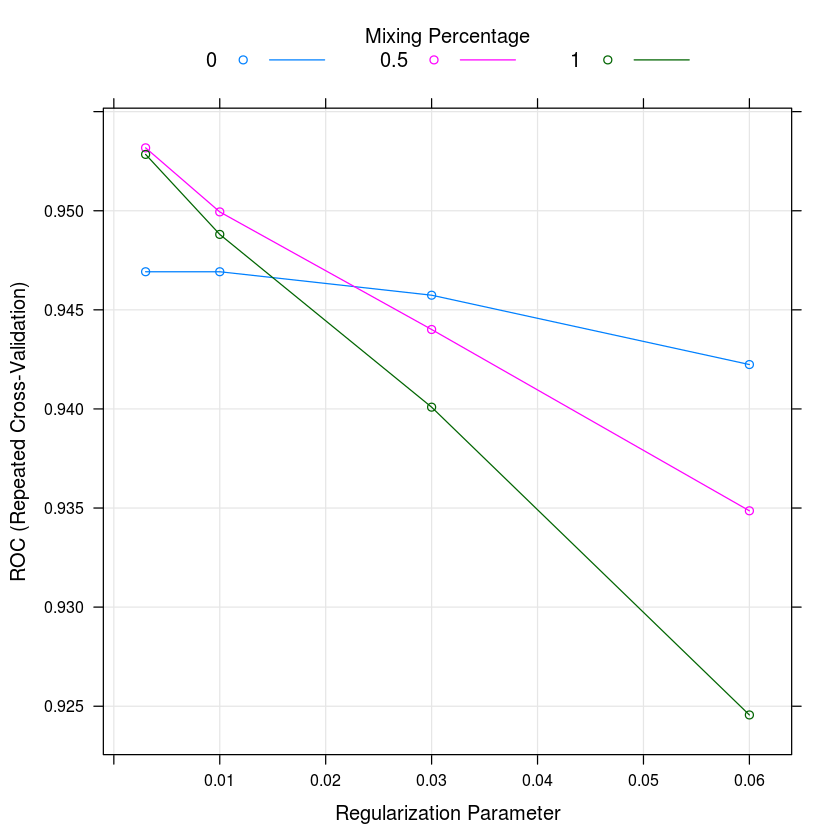

In [10]:
# Importing caret and setting a reproducible seed
library(caret)
set.seed(12345)

# Create a tuning grid with sets of hyperparameters to try
tuneGrid <- expand.grid(alpha = c(0, 0.5, 1), lambda = c(.003, .01, .03, .06))

# Create settings for model training
trControl <- trainControl(method = 'repeatedcv', number = 5, repeats = 1,
  classProbs = TRUE, verboseIter = FALSE, summaryFunction = twoClassSummary)

# Fitting a statistical model to the data and plot
model_fit <- train(
  observation ~ ., data = model_data,
  method = "glmnet", family = "binomial", metric = "ROC",
  tuneGrid = tuneGrid, trControl = trControl)

plot(model_fit)

## 10. Prediction probabilities
<p>We have now built our first species distribution model. Next, we will use it to predict the probability of occurrence for Scottish crossbill across the UK. We will make a prediction for each decade and each cell of the grid. Since we fit a logistic regression model, we can choose to predict the probability. In our case, this becomes the "probability of occurrence" for our species.</p>

In [11]:
# Use the model to make a prediction
climate_df[["prediction"]] <- predict(
    object = model_fit,
    newdata = climate_df,
    type = "prob")[["presence"]]

head(climate_df)

decade,minimum.temperature,maximum.temperature,rainfall,wind.speed,snow.lying,air.frost,x,y,prediction
1970,5.180083,9.764917,101.50867,14.66736,0.888750,2.541167,227500,972500,0.03820425
1970,4.422417,8.400500,119.00492,18.30500,1.768333,3.757833,232500,972500,0.04426503
1970,5.199667,10.947667,74.00758,12.15764,1.241000,3.136417,307500,972500,0.10089482
1970,4.771250,10.619250,71.86208,11.51333,1.569750,4.126000,322500,972500,0.21359648
1970,5.486250,10.478667,92.30558,11.77028,1.107833,2.875833,222500,967500,0.06564189
1970,4.464667,9.324833,114.34383,15.10250,1.477417,4.422417,227500,967500,0.05684158


## 11. Visualizing the predictions
<p>We have our predictions, but they are not in a digestible format. It is tough to figure out what is going on from that large table of numbers.</p>
<p>It would be great to visualize the predictions so we can see the patterns and how they change over time. A picture says more than a thousand words. We will create another map that shows our predictions of a changing climate in the UK, from 1965 to 2015.</p>

Loading required package: viridisLite


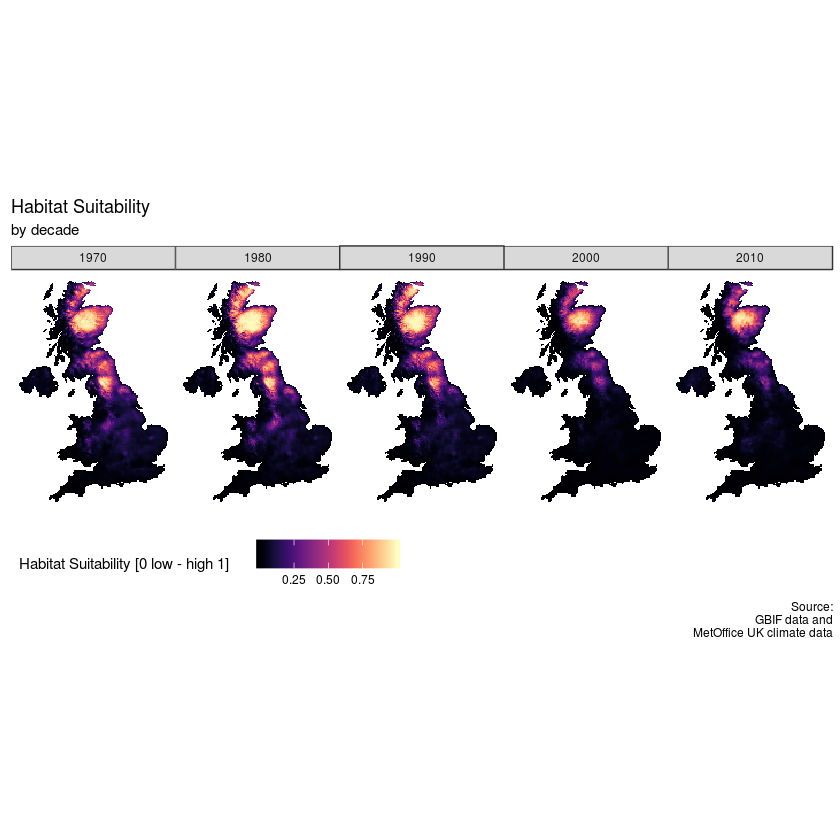

In [12]:
library(viridis)

# Creating the plot
ggp_changemap <- climate_df %>%
    ggplot(aes(x = x, y = y)) + 
    geom_tile(aes(fill = prediction)) +
     theme_map()+
    coord_equal()+
    scale_fill_viridis(option = "A") + theme(legend.position = "bottom") +
    facet_grid(~ decade)+
    labs(title = 'Habitat Suitability', subtitle = 'by decade',
       caption = 'Source:\nGBIF data and\nMetOffice UK climate data',
       fill = 'Habitat Suitability [0 low - high 1]')

ggp_changemap